# Sonar Data Classification with Logistic Regression

This notebook demonstrates the classification of sonar signals into **Rock (R)** or **Mine (M)** using Logistic Regression. We'll go through data preprocessing, outlier removal, scaling, model training, and visualization of results.

## Import Libraries

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 


## Load and Inspect Dataset

In [2]:

data = pd.read_csv('Copy of sonar data.csv', header=None) 
data = data.drop_duplicates()
data.head()


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Outlier Detection and Cleaning

In [3]:

Q1 = data.iloc[:, :-1].quantile(0.25) 
Q3 = data.iloc[:, :-1].quantile(0.75) 
IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
outlier_condition = ((data.iloc[:, :-1] < lower_bound) | (data.iloc[:, :-1] > upper_bound)).any(axis=1) 
data_clean = data[~outlier_condition] 


## Feature and Target Separation

In [4]:

X = data_clean.drop(columns=60, axis=1) 
y = data_clean[60] 


## Data Scaling

In [5]:

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) 


## Train-Test Split

In [6]:

X_train, X_test, y_train, y_test = train_test_split( 
    X_scaled, y, test_size=0.2, stratify=y, random_state=42 
) 


## Logistic Regression Model Training

In [7]:

model = LogisticRegression(random_state=42, max_iter=1000) 
model.fit(X_train, y_train) 

train_pred = model.predict(X_train) 
test_pred = model.predict(X_test) 


## Data Visualizations

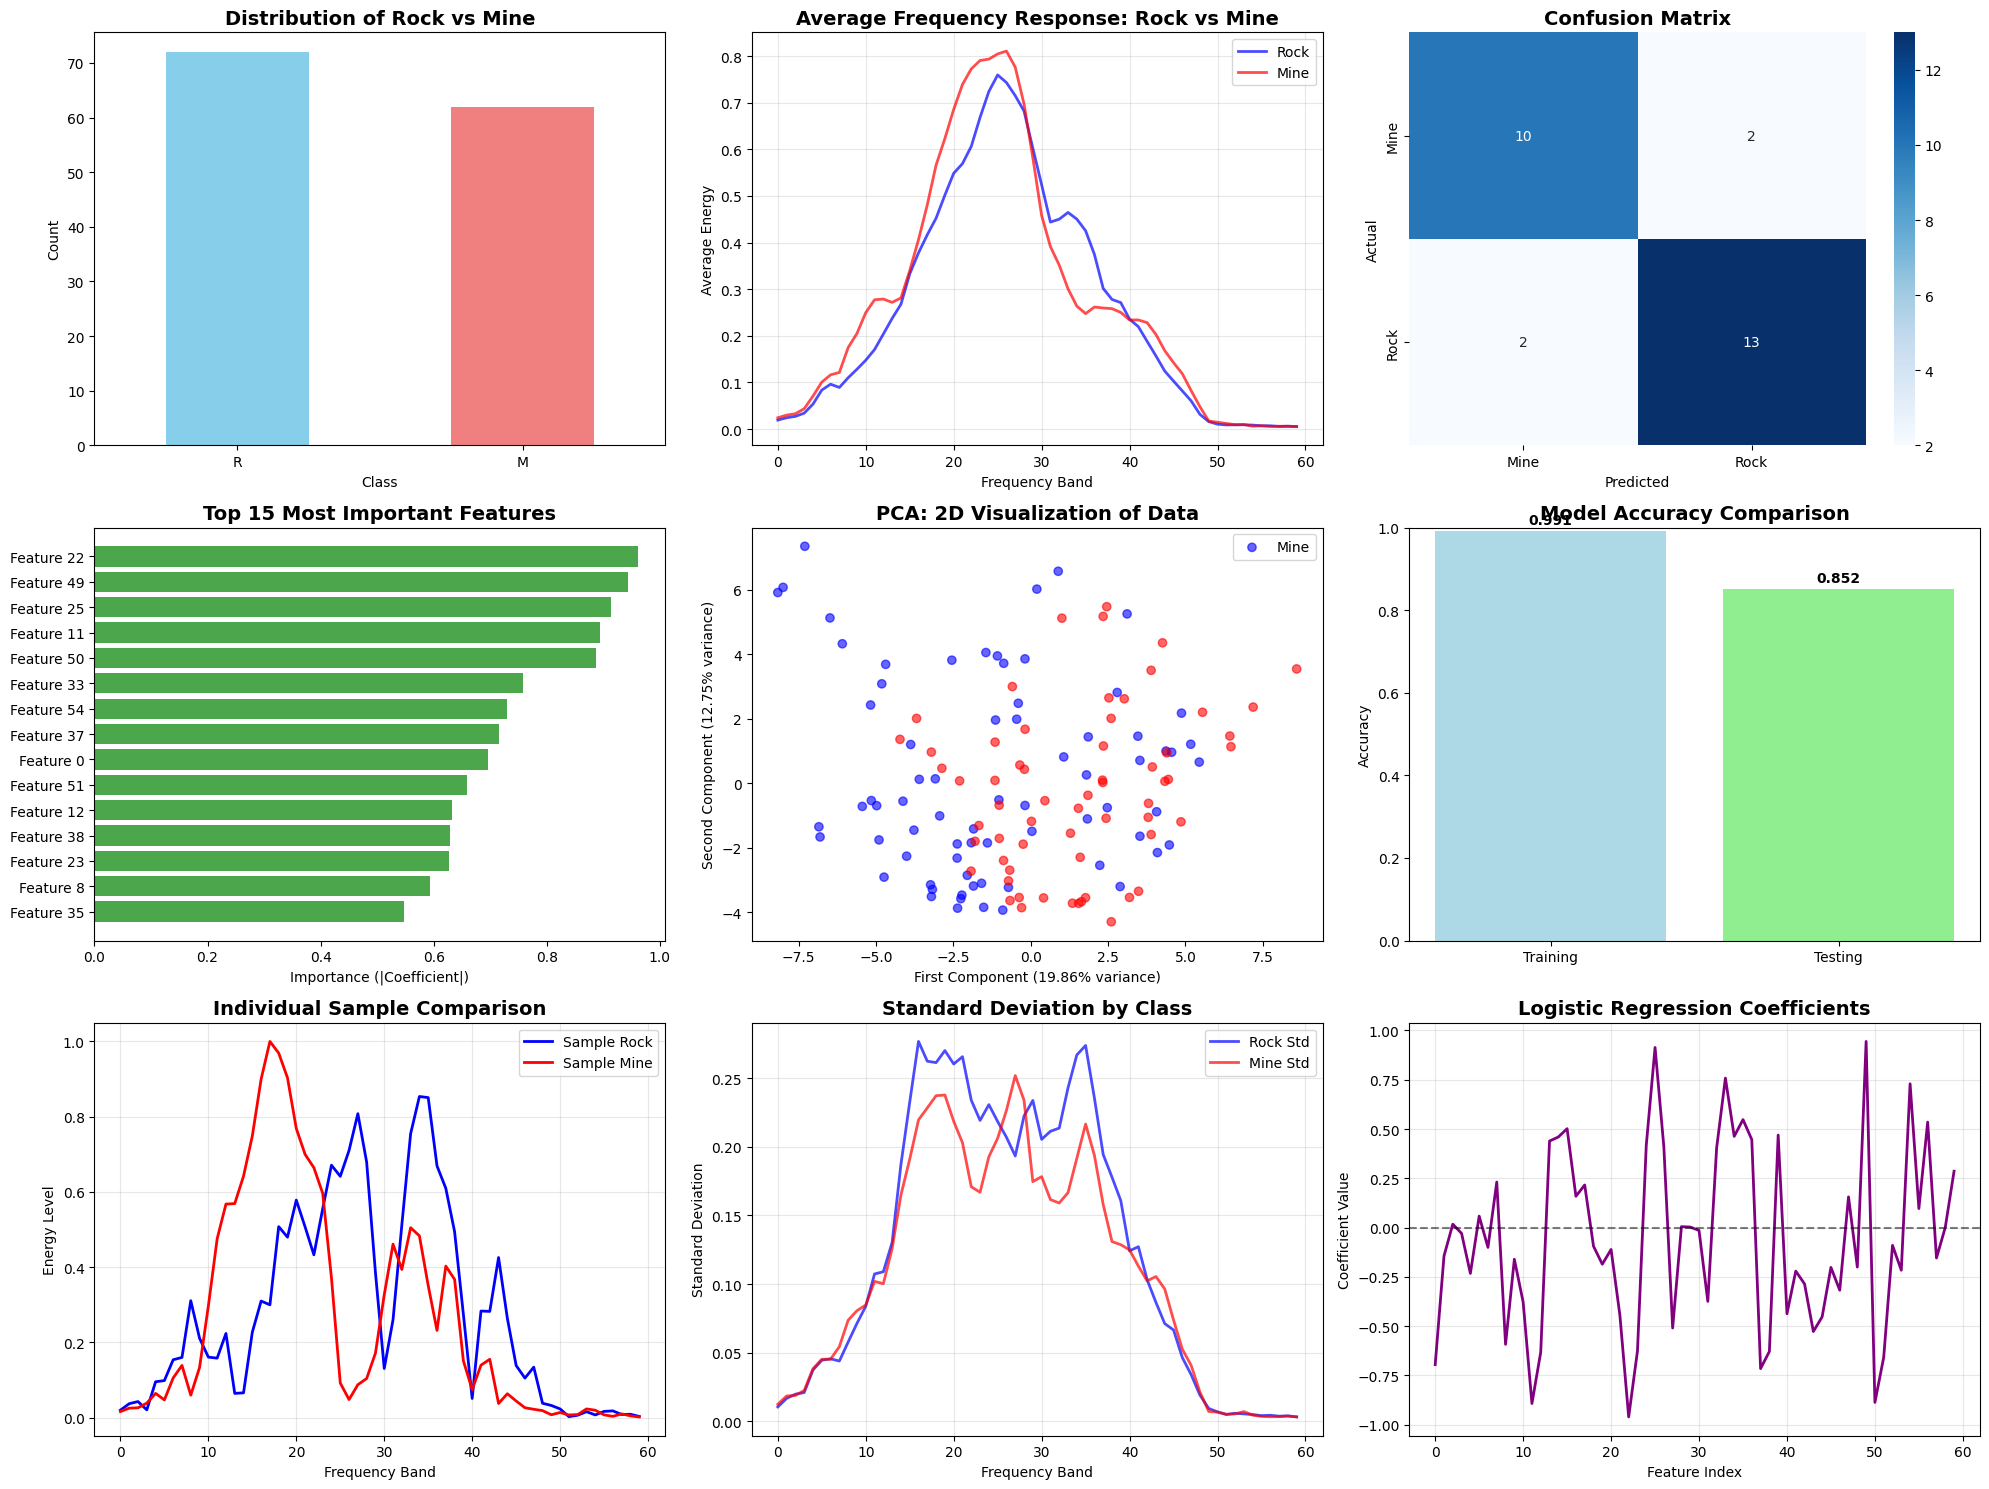

In [8]:

plt.style.use('default') 
fig = plt.figure(figsize=(20, 15)) 

plt.subplot(3, 3, 1) 
y.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral']) 
plt.title('Distribution of Rock vs Mine', fontsize=14, fontweight='bold') 
plt.xlabel('Class') 
plt.ylabel('Count') 
plt.xticks(rotation=0) 

plt.subplot(3, 3, 2) 
feature_means_rock = X[y == 'R'].mean() 
feature_means_mine = X[y == 'M'].mean() 
plt.plot(range(60), feature_means_rock, 'b-', label='Rock', alpha=0.7, linewidth=2) 
plt.plot(range(60), feature_means_mine, 'r-', label='Mine', alpha=0.7, linewidth=2) 
plt.title('Average Frequency Response: Rock vs Mine', fontsize=14, fontweight='bold') 
plt.xlabel('Frequency Band') 
plt.ylabel('Average Energy') 
plt.legend() 
plt.grid(True, alpha=0.3) 

plt.subplot(3, 3, 3) 
cm = confusion_matrix(y_test, test_pred) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mine', 'Rock'], yticklabels=['Mine', 'Rock']) 
plt.title('Confusion Matrix', fontsize=14, fontweight='bold') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 

plt.subplot(3, 3, 4) 
feature_importance = abs(model.coef_[0]) 
top_features = np.argsort(feature_importance)[-15:] 
plt.barh(range(15), feature_importance[top_features], color='green', alpha=0.7) 
plt.yticks(range(15), [f'Feature {i}' for i in top_features]) 
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold') 
plt.xlabel('Importance (|Coefficient|)') 

plt.subplot(3, 3, 5) 
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_scaled) 
colors = ['red' if label == 'M' else 'blue' for label in y] 
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6) 
plt.title('PCA: 2D Visualization of Data', fontsize=14, fontweight='bold') 
plt.xlabel(f'First Component ({pca.explained_variance_ratio_[0]:.2%} variance)') 
plt.ylabel(f'Second Component ({pca.explained_variance_ratio_[1]:.2%} variance)') 
plt.legend(['Mine', 'Rock']) 

plt.subplot(3, 3, 6) 
accuracies = [accuracy_score(y_train, train_pred), accuracy_score(y_test, test_pred)] 
bars = plt.bar(['Training', 'Testing'], accuracies, color=['lightblue', 'lightgreen']) 
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold') 
plt.ylabel('Accuracy') 
plt.ylim(0, 1) 
for bar, acc in zip(bars, accuracies): 
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,  
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold') 

plt.subplot(3, 3, 7) 
sample_rock = X[y == 'R'].iloc[0] 
sample_mine = X[y == 'M'].iloc[0] 
plt.plot(range(60), sample_rock, 'b-', label='Sample Rock', linewidth=2) 
plt.plot(range(60), sample_mine, 'r-', label='Sample Mine', linewidth=2) 
plt.title('Individual Sample Comparison', fontsize=14, fontweight='bold') 
plt.xlabel('Frequency Band') 
plt.ylabel('Energy Level') 
plt.legend() 
plt.grid(True, alpha=0.3) 

plt.subplot(3, 3, 8) 
feature_std_rock = X[y == 'R'].std() 
feature_std_mine = X[y == 'M'].std() 
plt.plot(range(60), feature_std_rock, 'b-', label='Rock Std', alpha=0.7, linewidth=2) 
plt.plot(range(60), feature_std_mine, 'r-', label='Mine Std', alpha=0.7, linewidth=2) 
plt.title('Standard Deviation by Class', fontsize=14, fontweight='bold') 
plt.xlabel('Frequency Band') 
plt.ylabel('Standard Deviation') 
plt.legend() 
plt.grid(True, alpha=0.3) 

plt.subplot(3, 3, 9) 
coef_values = model.coef_[0] 
plt.plot(range(60), coef_values, 'purple', linewidth=2) 
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5) 
plt.title('Logistic Regression Coefficients', fontsize=14, fontweight='bold') 
plt.xlabel('Feature Index') 
plt.ylabel('Coefficient Value') 
plt.grid(True, alpha=0.3) 

plt.tight_layout() 
plt.show() 


## Dataset Statistics and Model Performance

In [9]:

print("Dataset Statistics:") 
print(f"Original shape: {data.shape}") 
print(f"After cleaning: {data_clean.shape}") 
print(f"Outliers removed: {data.shape[0] - data_clean.shape[0]}") 
print(f"\nClass Distribution:") 
print(y.value_counts()) 
print(f"\nModel Performance:") 
print(f"Training Accuracy: {accuracy_score(y_train, train_pred):.4f}") 
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}") 
print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}") 
print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.4f}") 


Dataset Statistics:
Original shape: (208, 61)
After cleaning: (134, 61)
Outliers removed: 74

Class Distribution:
60
R    72
M    62
Name: count, dtype: int64

Model Performance:
Training Accuracy: 0.9907
Test Accuracy: 0.8519

PCA Explained Variance Ratio: [0.19862293 0.12746018]
Total variance explained by 2 components: 0.3261


## Top 10 Most Important Features

In [10]:

top_features_idx = np.argsort(feature_importance)[-10:][::-1] 
print(f"\nTop 10 Most Important Features:") 
for i, feat_idx in enumerate(top_features_idx, 1): 
    print(f"{i:2d}. Feature {feat_idx:2d}: {feature_importance[feat_idx]:.4f}") 



Top 10 Most Important Features:
 1. Feature 22: 0.9613
 2. Feature 49: 0.9444
 3. Feature 25: 0.9138
 4. Feature 11: 0.8932
 5. Feature 50: 0.8874
 6. Feature 33: 0.7584
 7. Feature 54: 0.7296
 8. Feature 37: 0.7158
 9. Feature  0: 0.6959
10. Feature 51: 0.6590


## Sample Prediction and Visualization


Sample Prediction:
Predicted class: M (Mine)
Prediction probabilities: [0.98652708 0.01347292]
Confidence: 0.9865


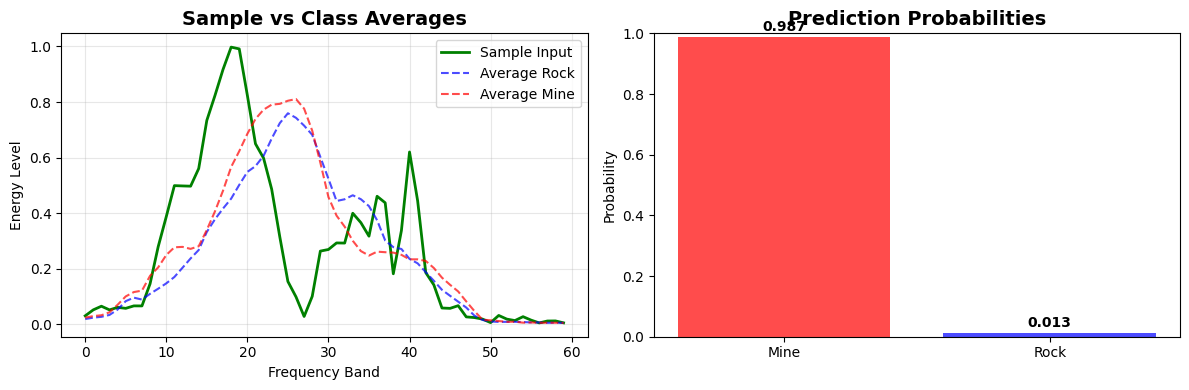

In [11]:

sample_input = np.array([[0.0307,0.0523,0.0653,0.0521,0.0611,0.0577,0.0665,0.0664,0.1460,0.2792, 
                         0.3877,0.4992,0.4981,0.4972,0.5607,0.7339,0.8230,0.9173,0.9975,0.9911, 
                         0.8240,0.6498,0.5980,0.4862,0.3150,0.1543,0.0989,0.0284,0.1008,0.2636, 
                         0.2694,0.2930,0.2925,0.3998,0.3660,0.3172,0.4609,0.4374,0.1820,0.3376, 
                         0.6202,0.4448,0.1863,0.1420,0.0589,0.0576,0.0672,0.0269,0.0245,0.0190, 
                         0.0063,0.0321,0.0189,0.0137,0.0277,0.0152,0.0052,0.0121,0.0124,0.0055]]) 

sample_scaled = scaler.transform(sample_input) 
prediction = model.predict(sample_scaled) 
probabilities = model.predict_proba(sample_scaled) 

print(f"\nSample Prediction:") 
print(f"Predicted class: {prediction[0]} ({'Rock' if prediction[0]=='R' else 'Mine'})") 
print(f"Prediction probabilities: {probabilities[0]}") 
print(f"Confidence: {max(probabilities[0]):.4f}") 

plt.figure(figsize=(12, 4)) 
plt.subplot(1, 2, 1) 
plt.plot(range(60), sample_input[0], 'g-', linewidth=2, label='Sample Input') 
plt.plot(range(60), feature_means_rock, 'b--', alpha=0.7, label='Average Rock') 
plt.plot(range(60), feature_means_mine, 'r--', alpha=0.7, label='Average Mine') 
plt.title('Sample vs Class Averages', fontsize=14, fontweight='bold') 
plt.xlabel('Frequency Band') 
plt.ylabel('Energy Level') 
plt.legend() 
plt.grid(True, alpha=0.3) 

plt.subplot(1, 2, 2) 
prob_labels = ['Mine', 'Rock'] if model.classes_[0] == 'M' else ['Rock', 'Mine'] 
plt.bar(prob_labels, probabilities[0], color=['red', 'blue'], alpha=0.7) 
plt.title('Prediction Probabilities', fontsize=14, fontweight='bold') 
plt.ylabel('Probability') 
plt.ylim(0, 1) 
for i, prob in enumerate(probabilities[0]): 
    plt.text(i, prob + 0.02, f'{prob:.3f}', ha='center', fontweight='bold') 

plt.tight_layout() 
plt.show() 
